<span style="font-family: serif; font-size: 2em;">
Airline Project
</span>


<span style="font-family: serif; font-size: 1.5em;">
Import dependencies
</span>

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# created dependencies
from feature_engineering_000 import *
from data_wrangling_000 import *

<span style="font-family: serif; font-size: 1.5em;">
Load and preprocess csv into dataframes
</span>

In [2]:
# get csv files from directory into list: NOTE! CSV files must be in same directory as code (I was unable to zip them)
csv_files_list = glob.glob('*.csv')


In [3]:
# create dataframes from list of csv files (function buggy in notebook, so loading manually)
airport_codes_initial = pd.read_csv('Airport_Codes.csv')
tickets_initial = pd.read_csv('Tickets.csv')
flights_initial = pd.read_csv('Flights.csv')

# create list of dataframes; loading manually as quick fix
#df_list = [airport_codes_initial, tickets_initial, flights_initial]

# process dataframes manually (original function in data wrangling file buggy in notebook)
airport_codes_initial = process_dataframe(airport_codes_initial)
tickets_initial = process_dataframe(tickets_initial)
flights_initial = process_dataframe(flights_initial)

c:\Users\marce\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<span style="font-family: serif; font-size: 1em;">
Above I do some preliminary pre-processing (manually since a data wrangling function I wrote was buggy). I drop duplicate rows from
all the dataframes. This was needed since duplication would negatively impact the accuracy of the analysis to come and since multiple dataframes had duplicate rows. 
</span>


<span style="font-family: serif; font-size: 1.5em;">
QUALITY CHECK / INITIAL WRANGLING
</span>

In [4]:
# Airport codes

# Subset airport codes to return only US airports for medium and large airports
airport_codes_v1 = dw_subset_airport_codes_for_m_l_airports_US_only(airport_codes_initial)

# note NaN values for airport codes
airport_codes_v1[airport_codes_v1['iata_code'].isna()].shape

(37, 8)

<span style="font-family: serif; font-size: 1em;">
There are 37 airports with missing 'iata_codes' including one apparent entry for 
one of the world's major airports Hartsfield Jackson Atlanta International Airport.
An analysis omitting this airport would likely be very problematic.
</span>


In [5]:
# ATL present in the dataframe
airport_codes_v1[airport_codes_v1['iata_code'] == 'ATL']

,type,name,elevation_ft,continent,iso_country,municipality,iata_code,coordinates
26266,large_airport,Hartsfield Jackson Atlanta International Airport,1026.0,NaN,US,Atlanta,ATL,"-84.428101, 33.6367"


<span style="font-family: serif; font-size: 1em;">
I quickly confirmed that the dataframe nevertheless has the relevant entry for
that airport. For that reason, and for the sake of expediency I chose to ignore the
remaining NaN values which concern medium sized airports. 
They will be ommitted by merging later. A more thorough analysis
would seek to confirm that these values are in the main dataset like 'ATL'
and to replace them with the correct codes when necessary, using other data.
</span>

In [6]:
# subset airport codes to keep only 'type' and 'iata_code' columns
airport_codes_v2 = dw_subset_airport_codes_for_merger(airport_codes_v1)

airport_codes_v2.head()

,type,iata_code
6194,medium_airport,WKK
25963,medium_airport,NaN
26143,medium_airport,ABE
26144,medium_airport,ABI
26145,large_airport,ABQ


<span style="font-family: serif; font-size: 1em;">
I will retain only the type and iata_code column for simplicity, though the coordinate
column could be highly useful for impressive visualizations in a more thorough report.
</span>

In [7]:
# Flights 


# subset flights to retain only non-canceled flights
flights_v1 = dw_subset_flights_not_cancelled_only(flights_initial)

# confirmation: no rows remain in this subset
flights_v1[flights_v1['cancelled'] == 1.0].shape


(0, 16)

In [8]:
# problem: 'distance' column contains troublesome strings
flights_v1['distance'].dtype


dtype('O')

In [9]:
# convert to dtype int
flights_v2 = dw_convert_distance_column_to_int(flights_v1)

Successfully converted 'distance' column to dtype int.


c:\Users\marce\Desktop\MA_submission\data_wrangling_000.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_numeric(df[column_name], errors='coerce', downcast='integer')


<span style="font-family: serif; font-size: 1em;">
The datatype of the 'distance' column is an object. Having it as a numeric data type 
is much better. I will use a function to convert the type to integers since an earlier
attempt to convert to floats was not sucessful.
</span>

In [10]:
# note: a small number of NaN values
flights_v2[flights_v2['distance'].isna()].shape

(268, 16)

<span style="font-family: serif; font-size: 1em;">
After the conversion there are now 268 rows where a valule for 'distance' is missing.
This is a relatively small number since the flights dataframe has nearly 2 million rows.
Further, null values will be ommited from aggregation calculations further below. 
For these reasons I will simply ignore these NaN values.
</span>

In [11]:
# problem: 'air_time' column contains strings as well
flights_v2['air_time'].dtype

dtype('O')

<span style="font-family: serif; font-size: 1em;">
The 'air_time' column is also an object datatype. I use the function below to convert 
its values to floats.
</span>

In [12]:
# convert dtype to float
flights_v3 = dw_convert_air_time_column_to_float(flights_v2)

Successfully converted 'air_time' column to dtype float.


c:\Users\marce\Desktop\MA_submission\data_wrangling_000.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_numeric(df[column_name], errors='coerce')


In [13]:
# inspect column datatype
flights_v3['air_time'].dtype

dtype('float64')

In [14]:
# revisit shape of flights data
flights_v3[flights_v3['air_time'].isna()].shape

(4616, 16)

<span style="font-family: serif; font-size: 1em;">
Fewer than 5000 null values remain. Ideally I would impute mean route air time values for these
missing values. But for the sake of expediency, and since 5000 values are comparatively few
in the dataframe, I will simply ignore these missing values. I will be grouping by a new route
column later and computing means for this column. The nulls will be omitted from the 
calculation. 
</span>

In [15]:
# Tickets 


# A function to subset tickts for only round trip samples
tickets_v1 = dw_subset_tickets_roundtrip_only(tickets_initial)

tickets_v1[tickets_v1['roundtrip'] == 0.0].shape

(0, 12)

<span style="font-family: serif; font-size: 1em;">
Here I confirm that no non-round trips remain in the dataset.
</span>

In [16]:
# problem: we need to convert datatypes again
tickets_v1['itin_fare'].dtype

dtype('O')

In [17]:
# convert using function
tickets_v2 = dw_convert_itin_fare_column_to_float(tickets_v1)

c:\Users\marce\Desktop\MA_submission\data_wrangling_000.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['itin_fare'] = pd.to_numeric(df['itin_fare'], errors='coerce').astype(float)


In [18]:
# problem: 'itin_fare' has an unusual mode value and frequency
tickets_v2['itin_fare'].value_counts().head(20)

11.0     27216
0.0       5752
358.0     1599
298.0     1588
378.0     1563
318.0     1547
278.0     1511
316.0     1494
398.0     1476
376.0     1466
388.0     1462
356.0     1461
296.0     1456
396.0     1453
336.0     1451
386.0     1439
338.0     1420
348.0     1414
374.0     1409
326.0     1407
Name: itin_fare, dtype: int64

<span style="font-family: serif; font-size: 1em;">
Looking at the top 20 most frequent values in the 'itin_fare' column we see an anomaly. 
The value of 11.0 occurs over 27,000 times -- nearly five times more frequently than 
the next most common value (0.0), and nearly twenty times more frequently than the next several
most common values. I assume this is an error.

I will leave the 0.0 values as they are: I assme they are free fares awarded for various reasons.

But I will need to impute values for this unusual 11.0 fare value.
</span>

In [19]:
# imputing mean itin_fare values, grouping by airline carrier
tickets_v3 = dw_replace_itin_fare_with_group_mean(tickets_v2) 
tickets_v3['itin_fare'].value_counts().head(20)

395.140387    8158
0.000000      5752
541.727941    5386
586.524211    5124
527.944461    2056
358.000000    1599
298.000000    1588
378.000000    1563
318.000000    1547
278.000000    1511
316.000000    1494
398.000000    1476
376.000000    1466
388.000000    1462
356.000000    1461
296.000000    1456
396.000000    1453
336.000000    1451
386.000000    1439
338.000000    1420
Name: itin_fare, dtype: int64

<span style="font-family: serif; font-size: 1em;">
I decided it would suffice to replace the 11.0 values with the mean fare values 
of the respective airline carrier. This function does that. Now the mode is one of 
the mean values for a carrier that previously had 8000 cases of 11.0 values. The imputation worked. 
</span>

In [20]:
# observation: tickets indicating plane with capacity greater than 200
tickets_v3['passengers'].unique()

array([  1.,   2.,   4.,   3.,   6.,   5.,   9.,  13.,   7.,  12.,  11.,
        53.,  21.,  17.,   8.,  36., 192.,  10.,  16.,  35.,  14.,  37.,
        26.,  19.,  22.,  40.,  15.,  18., 122.,  51.,  61.,  30.,  20.,
        24.,  31.,  25.,  33.,  48.,  27.,  28.,  47.,  29.,  23.,  50.,
        56.,  57.,  34.,  72.,  73.,  32.,  39.,  80.,  66.,  42.,  38.,
        89.,  45., 167., 135.,  49.,  43.,  41.,  nan,  60.,  62.,  74.,
       115.,  70.,  54., 255.,  55., 227.,  46., 164.,  67., 171., 280.,
        68., 365.,  65.,  88.,  91.,  76., 178.,  44.,  59.,  63.,  58.,
        93., 104., 105.,  75.,  52.,  86., 165., 108., 181., 243., 103.,
        82., 306., 117.,  79., 148., 130.,  90.,  87.,  77.,  64., 129.,
       157., 258., 177.,  83., 143., 203., 153.,  71., 102., 111.,  69.,
       170., 107.,  94., 131., 144.,  95.,  81.,  92., 133., 125., 156.,
       172., 186., 114.,  99., 138., 197., 100.,  84.,  97., 195.,  78.,
       127., 101., 180., 213., 681., 471., 175., 22

<span style="font-family: serif; font-size: 1em;">
Interestingly some of the tickets are for large passenger groups well over 200. 
Since the client in this case only expects to have flights that seat up to 200 
passengers per plane, a more extensive analysis might filter out some of these cases. 
For now I leave them in and simply note this issue.

This concludes the data quality check. 
</span>

<span style="font-family: serif; font-size: 1.5em;">
DATA MUNGING
</span>

In [21]:
# merge preparation: create the (freature engineered) fe_route column
flights_w_routes = fe_create_route(flights_v3)
tickets_w_routes = fe_create_route(tickets_v3)

c:\Users\marce\Desktop\MA_submission\feature_engineering_000.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fe_route'] = df.apply(lambda row: '_'.join(sorted([row['origin'], row['destination']])), axis=1)


<span style="font-family: serif; font-size: 1em;">
I need to identify roundtrip routes to provide relevant guidance to the client about
which routes are most traveled, most profitable, and so on. To do so I will need to
create a new routes column, 'fe_routes'. This will aid in joining data from the flights 
and tickets dataframes. 

I created a function that sorts the airport codes in 'origin' and 'destination' columns 
and joins them with an underscore. This identifies distinct round trip routes.
I apply this function to the flights and tickets dataframes. 
</span>

In [22]:
# new routes column confirmed
flights_w_routes[['origin', 'destination', 'fe_route']].head()

,origin,destination,fe_route
0,RSW,CLE,CLE_RSW
1,RSW,CMH,CMH_RSW
2,RSW,CMH,CMH_RSW
3,RSW,CMH,CMH_RSW
4,RSW,DAL,DAL_RSW


In [23]:
tickets_w_routes[['origin', 'destination', 'fe_route']].head()

,origin,destination,fe_route
0,ABI,DAB,ABI_DAB
1,ABI,COS,ABI_COS
2,ABI,MCO,ABI_MCO
3,ABI,LGA,ABI_LGA
10,ABI,JAX,ABI_JAX


In [24]:
# merege preparation: 
# derive mean ticket fares per passenger per route
# group by route, calculate mean of itin_fare version of tickets
tickets_w_routes_grouped_v1 = dw_transform_calculate_mean_fare_by_route_to_merge_with_flights(tickets_w_routes)
tickets_w_routes_grouped_v1.head()

,fe_route,itin_fare
0,ABE_ABI,758.0
1,ABE_ABQ,534.0
2,ABE_AGS,391.0
3,ABE_AMA,654.0
4,ABE_ASE,742.0


<span style="font-family: serif; font-size: 1em;">
The tickets data is needed to assign ticket revenue to routes. But the tickets table is just a sample of actual tickets data. Because of this it is best to use an aggreate value for each route, like a mean. The function above groups the tickets data by route and calculates a mean value. Since the fares are total round trip price per passenger, the mean values are mean ticket fares per passenger for the route. This new, smaller dataframe will be merged with the flights data. 
</span>

In [25]:
# feature engineered column made explicit
tickets_w_routes_grouped_v2 = fe_create_mean_route_fare_per_passenger(tickets_w_routes_grouped_v1)
tickets_w_routes_grouped_v2.head()

,fe_route,fe_mean_route_fare_per_passenger
0,ABE_ABI,758.0
1,ABE_ABQ,534.0
2,ABE_AGS,391.0
3,ABE_AMA,654.0
4,ABE_ASE,742.0


<span style="font-family: serif; font-size: 1em;">
I apply a further function to simply rename the aggregated column 'itin_fare' to be 'fe_mean_route_fare_per_passenger', so that it is clear that feature engineering took place.
</span>

In [26]:
# merging tickets data with flights data
merged_flights_tickets_v1 = dw_merge_dataframes_with_fe_route(flights_w_routes, tickets_w_routes_grouped_v2)
merged_flights_tickets_v1.head()

,fl_date,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,destination,dest_city_name,dep_delay,arr_delay,cancelled,air_time,distance,occupancy_rate,fe_route,fe_mean_route_fare_per_passenger
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.0,-6.0,0.0,143.0,1025.0,0.97,CLE_RSW,326.837235
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-7.0,-22.0,0.0,137.0,1025.0,0.63,CLE_RSW,326.837235
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-16.0,-9.0,0.0,129.0,1025.0,0.98,CLE_RSW,326.837235
3,2019-03-24,UA,N14249,2267,11042,CLE,"Cleveland, OH",14635,RSW,"Fort Myers, FL",-10.0,-23.0,0.0,136.0,1025.0,0.76,CLE_RSW,326.837235
4,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-1.0,8.0,0.0,138.0,1025.0,0.36,CLE_RSW,326.837235


<span style="font-family: serif; font-size: 1em;">
This function perfoms an inner join, keeping all the flights data and joining all
rows of the tickets data whenever the routes match. In this way, routes now have
mean round trip ticket fares associated with them. The join is an inner join for the sake
of expediency. 
</span>

In [27]:
# merging airport size data with the previously merged flights and tickets data
master_df_initial = dw_merge_dataframes_with_origin_destination_sizes(merged_flights_tickets_v1, 
                                                                 airport_codes_v2, 
                                                                 airport_codes_v2)
master_df_initial.head()    

,fl_date,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,destination,dest_city_name,...,cancelled,air_time,distance,occupancy_rate,fe_route,fe_mean_route_fare_per_passenger,type_origin,iata_code_origin,type_destination,iata_code_destination
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.0,143.0,1025.0,0.97,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.0,137.0,1025.0,0.63,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.0,129.0,1025.0,0.98,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE
3,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.0,138.0,1025.0,0.36,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE
4,2019-03-10,UA,N11206,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.0,141.0,1025.0,0.45,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE


<span style="font-family: serif; font-size: 1em;">
This function now creates the first "master" dataframe that contains relevant data from each of the original flights, tickets, and airport codes datasets. It does so by joining the previously joined merged_flights_tickets_v1 dataframe with the airport_codes_v2 dataframe two times: once to obtain airport type information from the origin airport (using the suffix '_origin'), and second time to obtain type information for the destination airport (using the suffix '_destination'). 
</span>

In [28]:
# feature engineering before grouping: adding a route operation cost column 
master_df_w_route_airport_operations_cost = fe_calculate_route_airport_operations_cost(master_df_initial)
master_df_w_route_airport_operations_cost.head()

,fl_date,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,destination,dest_city_name,...,occupancy_rate,fe_route,fe_mean_route_fare_per_passenger,type_origin,iata_code_origin,type_destination,iata_code_destination,airport_origin_cost,airport_destination_cost,fe_route_airport_operations_cost
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.97,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE,10000,10000,20000
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.63,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE,10000,10000,20000
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.98,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE,10000,10000,20000
3,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.36,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE,10000,10000,20000
4,2019-03-10,UA,N11206,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",...,0.45,CLE_RSW,326.837235,large_airport,RSW,large_airport,CLE,10000,10000,20000


<span style="font-family: serif; font-size: 1em;">
Before further transforming the master dataframe we add columns that calculate the
route's airport operation costs based on the size of its airports. 
</span>

In [29]:
# transforming the master dataframe and ensuring the aggregated columns are properly named
master_df_grouped_by_route_v1 = dw_transform_calculate_varied_grouped_means_with_count(master_df_w_route_airport_operations_cost)
master_df_grouped_by_route_v2 = fe_create_multiple_mean_values_with_count(master_df_grouped_by_route_v1)
master_df_grouped_by_route_v2.head()

,fe_route,fe_route_mean_air_time,fe_route_mean_distance,fe_route_mean_occupancy_rate,fe_route_mean_dep_delay,fe_route_mean_arr_delay,fe_route_airport_operations_cost,fe_mean_route_fare_per_passenger,fe_route_distinct_op_carrier_count,fe_number_of_flights_per_route
0,ABE_ATL,99.700461,692.0,0.654332,6.873272,2.557604,15000,568.325885,2,434
1,ABE_CLT,85.551793,481.0,0.661096,3.838645,1.468127,15000,505.995864,1,502
2,ABE_DTW,71.721774,425.0,0.645392,13.663984,5.981855,15000,410.425927,2,497
3,ABE_FLL,147.425000,1041.0,0.605250,5.400000,4.250000,15000,256.945466,1,40
4,ABE_ORD,96.531447,654.0,0.649094,29.275000,23.666667,15000,565.030466,3,320


<span style="font-family: serif; font-size: 1em;">
The previous master dataframe has individual flight information. But we are after grouped information. 

This first function transforms that initial master dataframe grouping by route and extracting various mean and count values that will be the basis for the some of the final calculations. This second function renames some of the columns to make explicit that they are feature engineered.
</span>

In [30]:
# feature engineering the grouped master dataframe: 

<span style="font-family: serif; font-size: 1em;">
We now add several remaining feature engineered columns to the master dataframe.
These columns will facilitate the final analysis for the client. 
</span>

In [31]:
# add fe_route_delay_cost column
master_df_grouped_by_route_v3 = fe_calculate_route_delay_cost(master_df_grouped_by_route_v2)

# add fe_round_trip_route_dio_cost (depreciation, interest, other) column
master_df_grouped_by_route_v4 = fe_calculate_round_trip_route_dio_cost(master_df_grouped_by_route_v3)

# add fe_round_trip_route_fomc_cost (fuel, oil, maintenance, crew) column
master_df_grouped_by_route_v5 = fe_calculate_round_trip_route_fomc_cost(master_df_grouped_by_route_v4)

# add fe_round_trip_route_fare_revenue column
master_df_grouped_by_route_v6 = fe_calculate_round_trip_route_fare_revenue(master_df_grouped_by_route_v5)

# add fe_round_trip_route_baggage_revenue column
master_df_grouped_by_route_v7 = fe_calculate_round_trip_route_baggage_revenue(master_df_grouped_by_route_v6)

# add fe_round_trip_total_revenue column
master_df_grouped_by_route_v8 = fe_calculate_round_trip_total_revenue(master_df_grouped_by_route_v7)

# add fe_round_trip_total_variable_cost column
master_df_grouped_by_route_v9 = fe_calculate_round_trip_total_variable_cost(master_df_grouped_by_route_v8)

# add fe_per_round_trip_route_profit column
master_df_grouped_by_route_v10 = fe_calculate_per_round_trip_route_profit(master_df_grouped_by_route_v9)

# add fe_break_even_point_in_number_of_round_trip_flights_for_route column
master_df_grouped_by_route_v11 = fe_calculate_break_even_point_in_number_of_round_trip_flights_for_route(master_df_grouped_by_route_v10)
master_df_grouped_by_route_v11.head()

# add fe_total_profit_for_route_2019q1 column
master_df_grouped_by_route_v12 = fe_calculate_total_profit_for_route_2019q1(master_df_grouped_by_route_v11)
master_df_grouped_by_route_v12.head()


,fe_route,fe_route_mean_air_time,fe_route_mean_distance,fe_route_mean_occupancy_rate,fe_route_mean_dep_delay,fe_route_mean_arr_delay,fe_route_airport_operations_cost,fe_mean_route_fare_per_passenger,fe_route_distinct_op_carrier_count,fe_number_of_flights_per_route,fe_route_delay_cost,fe_round_trip_route_dio_cost,fe_round_trip_route_fomc_cost,fe_round_trip_route_fare_revenue,fe_round_trip_route_baggage_revenue,fe_round_trip_total_revenue,fe_round_trip_total_variable_cost,fe_per_round_trip_route_profit,fe_break_even_point_in_number_of_round_trip_flights_for_route,fe_total_profit_for_route_2019q1
0,ABE_ATL,99.700461,692.0,0.654332,6.873272,2.557604,15000,568.325885,2,434,0.000,1633.12,11072.0,148749.478995,9160.645161,157910.124157,27705.120,130205.004157,691.217673,5.650897e+07
1,ABE_CLT,85.551793,481.0,0.661096,3.838645,1.468127,15000,505.995864,1,502,0.000,1135.16,7696.0,133804.659246,9255.338645,143059.997891,23831.160,119228.837891,754.850937,5.985288e+07
2,ABE_DTW,71.721774,425.0,0.645392,13.663984,5.981855,15000,410.425927,2,497,0.000,1003.00,6800.0,105954.302009,9035.492958,114989.794966,22803.000,92186.794966,976.278653,4.581684e+07
3,ABE_FLL,147.425000,1041.0,0.605250,5.400000,4.250000,15000,256.945466,1,40,0.000,2456.76,16656.0,62206.497241,8473.500000,70679.997241,34112.760,36567.237241,2461.219572,1.462689e+06
4,ABE_ORD,96.531447,654.0,0.649094,29.275000,23.666667,15000,565.030466,3,320,1720.625,1543.44,10464.0,146703.097738,9087.312500,155790.410238,28728.065,127062.345238,708.313701,4.065995e+07


<span style="font-family: serif; font-size: 1.5em;">
RESPONSES TO QUESTIONS / VISUAL NARRATIVE
</span>

In [32]:
# Identify top 10 round trip routes with greatest number of flights in 2019 Q1
top_routes = master_df_grouped_by_route_v11.groupby(['fe_route'])['fe_number_of_flights_per_route'].mean().sort_values(ascending=False).head(10)

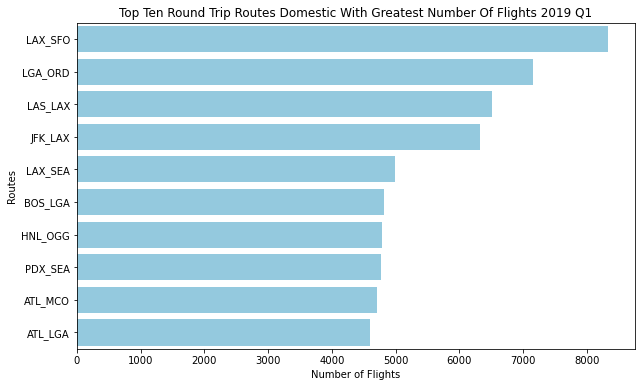

In [33]:
# Create a horizontal bar chart of these top 10 routes
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.barplot(x=top_routes.values, y=top_routes.index, color='skyblue')

# Set chart labels and title
plt.xlabel('Number of Flights')
plt.ylabel('Routes')
plt.title('Top Ten Round Trip Routes Domestic With Greatest Number Of Flights 2019 Q1')

# Show the chart
plt.show()

<span style="font-family: serif; font-size: 1em;">
Here we see that the domestic round trip routes with the most number of flights flown during Q1 of 2019 mostly center along major airports on the east and west coasts. These are high traffic hubs. 
</span>

In [34]:
# Identify top 10 most profitable routes in 2019 Q1

# Get columns for aggreation

columns = [
    'fe_total_profit_for_route_2019q1',
    'fe_round_trip_total_variable_cost',
    'fe_round_trip_total_revenue',
    'fe_per_round_trip_route_profit',
    'fe_round_trip_route_baggage_revenue',
    'fe_round_trip_route_fare_revenue',
    'fe_round_trip_route_fomc_cost',
    'fe_round_trip_route_dio_cost',
    'fe_route_delay_cost',
    'fe_route_airport_operations_cost',
    'fe_number_of_flights_per_route',
    'fe_route_distinct_op_carrier_count'
]

# Group by 'fe_route' and calculate the mean (redundant for many) for columns in list
grouped_profit_df = master_df_grouped_by_route_v12.groupby('fe_route')[columns].mean()

grouped_profit_df.nlargest(10, 'fe_total_profit_for_route_2019q1')


,fe_total_profit_for_route_2019q1,fe_round_trip_total_variable_cost,fe_round_trip_total_revenue,fe_per_round_trip_route_profit,fe_round_trip_route_baggage_revenue,fe_round_trip_route_fare_revenue,fe_round_trip_route_fomc_cost,fe_round_trip_route_dio_cost,fe_route_delay_cost,fe_route_airport_operations_cost,fe_number_of_flights_per_route,fe_route_distinct_op_carrier_count
fe_route,,,,,,,,,,,,
JFK_LAX,1.242995e+09,65441.000000,262117.379897,196676.379897,9101.041139,253016.338758,39600.000000,5841.000000,0.000000,20000,6320,4
JFK_SFO,6.274001e+08,67505.505284,236116.130808,168610.625524,9097.930664,227018.200144,41376.000000,6102.960000,26.545284,20000,3721,4
EWR_SFO,5.410048e+08,67580.683416,290767.502509,223186.819093,9098.671617,281668.830891,41040.000000,6053.400000,487.283416,20000,2424,2
LAX_SFO,5.067719e+08,26501.285501,87265.299974,60764.014472,9086.184652,78179.115321,5392.000000,795.320000,313.965501,20000,8340,7
LGA_ORD,5.040376e+08,34281.522206,104717.189565,70435.667359,9087.733371,95629.456195,11728.000000,1729.880000,823.642206,20000,7156,6
SLC_TWF,4.980701e+08,18213.000000,874003.489294,855790.489294,9352.577320,864650.911975,2800.000000,413.000000,0.000000,15000,582,1
ATL_LGA,4.507783e+08,33990.320000,132113.591411,98123.271411,9115.542011,122998.049399,12192.000000,1798.320000,0.000000,20000,4594,5
DCA_ORD,4.224744e+08,31236.320000,145573.099694,114336.779694,9070.901218,136502.198477,9792.000000,1444.320000,0.000000,20000,3695,6
BOS_LGA,3.929054e+08,23725.978589,105241.617018,81515.638429,9112.112033,96129.504985,2944.000000,434.240000,347.738589,20000,4820,5


<span style="font-family: serif; font-size: 1em;">
Here we have the top 10 most profitable routes for Q1 of 2019. Most of these routes are highly flown with roughly 3000 - 8000 flights in the quarter. But one -- SLC_TWF	-- has far fewer flights -- with 582. This suggests this route's profitability is highly efficient -- it takes fewer flights for this route to make more profit, compared to  other routes. Let's take a look at this with a scatter plot before moving on.
</span>

<Figure size 432x288 with 0 Axes>

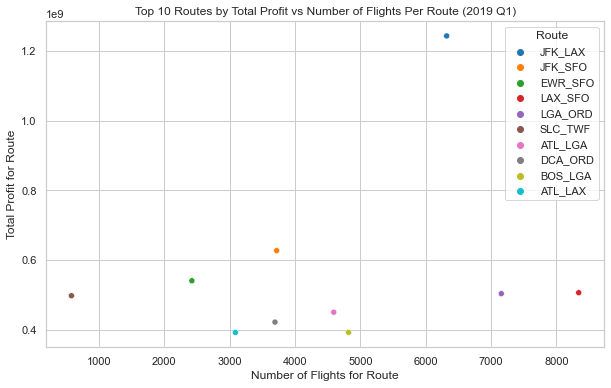

In [35]:
# set data for scatterplot
top_profit_routes_plot = grouped_profit_df.nlargest(10, 'fe_total_profit_for_route_2019q1')

# Clear the previous plot
plt.clf()

# Set up the scatterplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the scatterplot
scatter = sns.scatterplot(data=top_profit_routes_plot, x='fe_number_of_flights_per_route', y='fe_total_profit_for_route_2019q1', hue=top_profit_routes_plot.index, palette='tab10')

# Set labels and title
scatter.set(xlabel='Number of Flights for Route', ylabel='Total Profit for Route', title='Top 10 Routes by Total Profit vs Number of Flights Per Route (2019 Q1)')

# Add legend
plt.legend(title='Route')

# Show the plot
plt.show()

<span style="font-family: serif; font-size: 1.5em;">
Recommendations: leaning into the motto "On time, for you"
</span>

<span style="font-family: serif; font-size: 1em;">
Here is my summary about these recommendations.

</span>

In [36]:
# Recommendation 1:AUT_CMH
master_df_grouped_by_route_v12.sort_values(by='fe_route_delay_cost', ascending=False).head(1)

,fe_route,fe_route_mean_air_time,fe_route_mean_distance,fe_route_mean_occupancy_rate,fe_route_mean_dep_delay,fe_route_mean_arr_delay,fe_route_airport_operations_cost,fe_mean_route_fare_per_passenger,fe_route_distinct_op_carrier_count,fe_number_of_flights_per_route,fe_route_delay_cost,fe_round_trip_route_dio_cost,fe_round_trip_route_fomc_cost,fe_round_trip_route_fare_revenue,fe_round_trip_route_baggage_revenue,fe_round_trip_total_revenue,fe_round_trip_total_variable_cost,fe_per_round_trip_route_profit,fe_break_even_point_in_number_of_round_trip_flights_for_route,fe_total_profit_for_route_2019q1
260,AUS_CMH,135.5,1073.0,0.695,217.5,208.0,20000,423.137637,1,2,29662.5,2532.28,17168.0,117632.262964,9730.0,127362.262964,69362.78,57999.482964,1551.737971,115998.965928


<span style="font-family: serif; font-size: 1em;">
If the client has a competitive advantage in terms of punctulaity, one good route option to consider is a route where competition is the slowest. Beating the worst competition -- in terms of punctuality --might be low-hanging fruit. the AUS_CMH route is one where competition fares the worst. For expediency I have used a proxy for this measure, namely, the mean route delay cost column which takes into account both mean arrival and departure delays. The breakeven point for this route is roughly 1552 round trips.
</span>

<span style="font-family: serif; font-size: 1em;">
This is an interesting possibility for another reason. Compared to the other worst offenders of this metric, this route is nearly six times worse. We can see that in the chart below.
</span>

<Figure size 432x288 with 0 Axes>

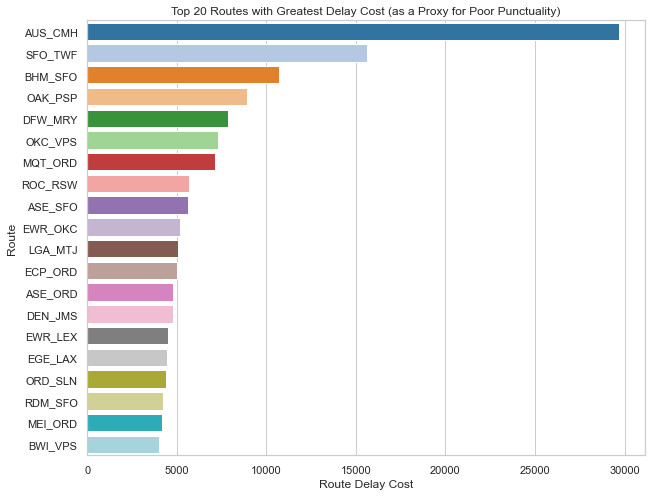

In [37]:
# Sort the DataFrame and get the top 20 routes
slow_competitors = master_df_grouped_by_route_v12.sort_values(by='fe_route_delay_cost', ascending=False).head(20)

# Clear the previous plot
plt.clf()

# Set up the bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create the bar plot
barplot = sns.barplot(data=slow_competitors, y='fe_route', x='fe_route_delay_cost', palette='tab20')

# Set labels and title
barplot.set(xlabel='Route Delay Cost', ylabel='Route', title='Top 20 Routes with Greatest Delay Cost (as a Proxy for Poor Punctuality)')

# Show the plot
plt.show()


In [38]:
# Recommendation 2: ABE_ATL
master_df_grouped_by_route_v12.sort_values(by='fe_route_delay_cost', ascending=True).head(1)

,fe_route,fe_route_mean_air_time,fe_route_mean_distance,fe_route_mean_occupancy_rate,fe_route_mean_dep_delay,fe_route_mean_arr_delay,fe_route_airport_operations_cost,fe_mean_route_fare_per_passenger,fe_route_distinct_op_carrier_count,fe_number_of_flights_per_route,fe_route_delay_cost,fe_round_trip_route_dio_cost,fe_round_trip_route_fomc_cost,fe_round_trip_route_fare_revenue,fe_round_trip_route_baggage_revenue,fe_round_trip_total_revenue,fe_round_trip_total_variable_cost,fe_per_round_trip_route_profit,fe_break_even_point_in_number_of_round_trip_flights_for_route,fe_total_profit_for_route_2019q1
0,ABE_ATL,99.700461,692.0,0.654332,6.873272,2.557604,15000,568.325885,2,434,0.0,1633.12,11072.0,148749.478995,9160.645161,157910.124157,27705.12,130205.004157,691.217673,5.650897e+07


<span style="font-family: serif; font-size: 1em;">
What if competitors are slow due to the airports themselves rather than something to do with the carriers? Or what if the client believes they are more punctual than even the most punctual competitors? 
</span>

<span style="font-family: serif; font-size: 1em;">
This leads to the recommendation of the ABE_ATL route. This route has the lowest value for 'fe_route_delay_cost' which is my rough proxy for punctuality. Perfoming well here would give strong support for the company's motto and help solidify punctuality as part of its image. This route also boasts another advantage: its breakeven point is only 692 flights allowing it to allow the client to quickly regain its investement.
</span>

In [39]:
# Recommendation 3: SLC_TWF
master_df_grouped_by_route_v12.sort_values(by=['fe_per_round_trip_route_profit', 'fe_route_mean_distance'], ascending=[False, True]).head(1)


,fe_route,fe_route_mean_air_time,fe_route_mean_distance,fe_route_mean_occupancy_rate,fe_route_mean_dep_delay,fe_route_mean_arr_delay,fe_route_airport_operations_cost,fe_mean_route_fare_per_passenger,fe_route_distinct_op_carrier_count,fe_number_of_flights_per_route,fe_route_delay_cost,fe_round_trip_route_dio_cost,fe_round_trip_route_fomc_cost,fe_round_trip_route_fare_revenue,fe_round_trip_route_baggage_revenue,fe_round_trip_total_revenue,fe_round_trip_total_variable_cost,fe_per_round_trip_route_profit,fe_break_even_point_in_number_of_round_trip_flights_for_route,fe_total_profit_for_route_2019q1
2785,SLC_TWF,33.575862,175.0,0.668041,6.59622,1.118966,15000,3235.769231,1,582,0.0,413.0,2800.0,864650.911975,9352.57732,874003.489294,18213.0,855790.489294,105.165927,4.980701e+08


<span style="font-family: serif; font-size: 1em;">
Fliers may be likely to associate punctuality with having a quick flight. This leads to my third recommended route of SLC_TWF. It is the most profitable route in terms of profit per round trip, that also has the shortest distance, in terms of mean route distance.
</span>

<span style="font-family: serif; font-size: 1em;">
I chose mean route distance as a proxy for "having a quick flight" since there were data complications with the other obvious choice: mean air time. Some of the values in that column appear to be reported in hours while others appear to be reported in minutes. 
</span>

<Figure size 432x288 with 0 Axes>

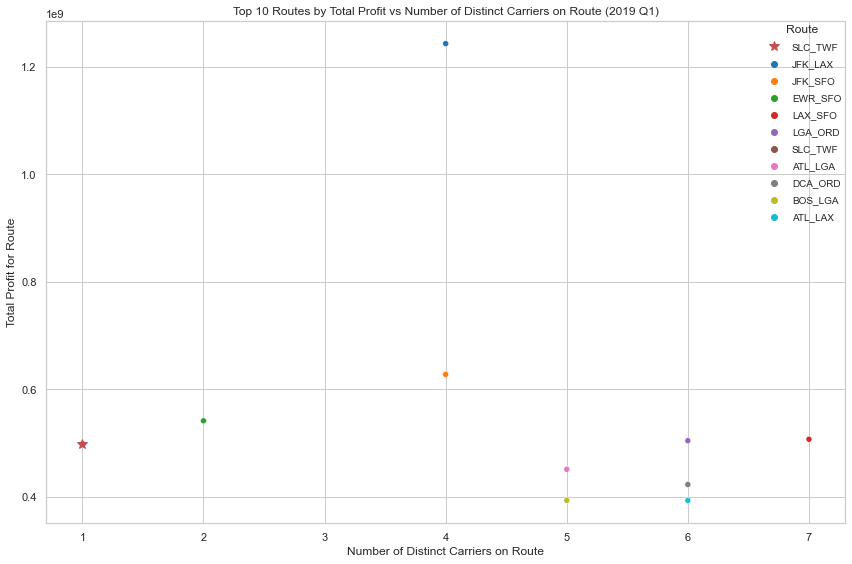

In [40]:
# Another advantage of SLC_TWF: Lack of Competition

# set data for scatterplot
top_profit_routes_plot_2 = grouped_profit_df.nlargest(10, 'fe_total_profit_for_route_2019q1')

# Clear the previous plot
plt.clf()

# Set up scatterplot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))  # Adjust the figsize as needed

# Create scatterplot
scatter = sns.scatterplot(
    data=top_profit_routes_plot_2,
    x='fe_route_distinct_op_carrier_count',
    y='fe_total_profit_for_route_2019q1',
    hue=top_profit_routes_plot_2.index,
    palette='tab10'
)

# Emphasize the point for 'SLC_TWF' in the plot itself
highlight_point = top_profit_routes_plot_2.loc['SLC_TWF']
scatter.plot(
    highlight_point['fe_route_distinct_op_carrier_count'],
    highlight_point['fe_total_profit_for_route_2019q1'],
    'r*', 
    markersize=10,
    label='SLC_TWF'
)

# Set labels and title
scatter.set(
    xlabel='Number of Distinct Carriers on Route',
    ylabel='Total Profit for Route',
    title='Top 10 Routes by Total Profit vs Number of Distinct Carriers on Route (2019 Q1)'
)

# Move the legend
plt.legend(
    title='Route',
    loc='upper right',
    prop={'size': 10},
    borderaxespad=0,
    frameon=False,
    labelspacing=0.8
)

# Adjust plot layout to prevent clipping of legend
plt.tight_layout()

# Show the plot
plt.show()

<span style="font-family: serif; font-size: 1em;">
Of the most profitable routes in Q1 2019, SLC_TWF not only has the shortest distance -- which may indirectly help cement the client's brand recognition -- but it also has the fewest number of current airline operators. This is great news for the client as it increases the likelihood that they will be able to capture a greater portion of the route's marketshare.
</span>

In [41]:
# Recommendation 4: CLT_FLO	the (second) fastest profitable route to break even

# Filter rows where 'fe_break_even_point_in_number_of_round_trip_flights_for_route' > 0
actually_profitable = master_df_grouped_by_route_v12[master_df_grouped_by_route_v12['fe_break_even_point_in_number_of_round_trip_flights_for_route'] > 0]

# Sort the filtered DataFrame by 'fe_break_even_point_in_number_of_round_trip_flights_for_route'
actually_profitable.sort_values(by='fe_break_even_point_in_number_of_round_trip_flights_for_route').head(2)


,fe_route,fe_route_mean_air_time,fe_route_mean_distance,fe_route_mean_occupancy_rate,fe_route_mean_dep_delay,fe_route_mean_arr_delay,fe_route_airport_operations_cost,fe_mean_route_fare_per_passenger,fe_route_distinct_op_carrier_count,fe_number_of_flights_per_route,fe_route_delay_cost,fe_round_trip_route_dio_cost,fe_round_trip_route_fomc_cost,fe_round_trip_route_fare_revenue,fe_round_trip_route_baggage_revenue,fe_round_trip_total_revenue,fe_round_trip_total_variable_cost,fe_per_round_trip_route_profit,fe_break_even_point_in_number_of_round_trip_flights_for_route,fe_total_profit_for_route_2019q1
2785,SLC_TWF,33.575862,175.0,0.668041,6.596220,1.118966,15000,3235.769231,1,582,0.0,413.00,2800.0,864650.911975,9352.577320,874003.489294,18213.00,855790.489294,105.165927,4.980701e+08
830,CLT_FLO,27.515873,99.0,0.648552,4.424603,1.315476,15000,1999.000000,1,504,0.0,233.64,1584.0,518581.849206,9079.722222,527661.571429,16817.64,510843.931429,176.179053,2.574653e+08


<span style="font-family: serif; font-size: 1em;">
Outward branding is one thing. But internal branding is another: it is also important for employees to embrace the motto "On time, for you" and gain a boost to their morale. Since entering the US market is a new venture for the client, regaining its investment "on time" (i.e. rapidly) may be a significant consideration -- and one that will help employees feel that, economically speaking, punctuality reigns. 
</span>

<span style="font-family: serif; font-size: 1em;">
The route that recoups its investment "on time" is SLC_TWF. But I've already recommended that one. The next best performer in this regard is CLT_FLO. It breaks even in after 177 round trip flights -- not bad.
</span>

In [42]:
# Recommendation 5: Tie: BRW_FAI & ANC_BRW for their minimal departure delay, quick break even point, and quarterly profitability
master_df_grouped_by_route_v12.sort_values(by='fe_route_mean_dep_delay').head()

,fe_route,fe_route_mean_air_time,fe_route_mean_distance,fe_route_mean_occupancy_rate,fe_route_mean_dep_delay,fe_route_mean_arr_delay,fe_route_airport_operations_cost,fe_mean_route_fare_per_passenger,fe_route_distinct_op_carrier_count,fe_number_of_flights_per_route,fe_route_delay_cost,fe_round_trip_route_dio_cost,fe_round_trip_route_fomc_cost,fe_round_trip_route_fare_revenue,fe_round_trip_route_baggage_revenue,fe_round_trip_total_revenue,fe_round_trip_total_variable_cost,fe_per_round_trip_route_profit,fe_break_even_point_in_number_of_round_trip_flights_for_route,fe_total_profit_for_route_2019q1
2253,MCI_VPS,103.250000,764.0,0.497500,-12.250000,-18.250000,20000,385.984652,1,4,0.0,1803.04,12224.0,76810.945742,6965.000000,83775.945742,34027.04,49748.905742,1809.085017,1.989956e+05
583,BRW_FAI,71.294118,503.0,0.695059,-11.705882,-9.929412,15000,443.069337,1,85,0.0,1187.08,8048.0,123183.700964,9730.823529,132914.524494,24235.08,108679.444494,828.123482,9.237753e+06
799,CLE_PIE,123.281250,932.0,0.630625,-11.343750,-14.593750,15000,189.066667,1,32,0.0,2199.52,14912.0,47692.066667,8828.750000,56520.816667,32111.52,24409.296667,3687.119757,7.810975e+05
2112,LAX_MSN,219.000000,1687.0,0.880000,-10.000000,-29.500000,20000,571.839239,1,2,0.0,3981.32,26992.0,201287.412231,12320.000000,213607.412231,50973.32,162634.092231,553.389506,3.252682e+05
80,ANC_BRW,96.942529,725.0,0.685172,-9.045977,-8.885057,15000,477.722074,1,87,0.0,1711.00,11600.0,130928.794635,9592.413793,140521.208428,28311.00,112210.208428,802.066062,9.762288e+06


<span style="font-family: serif; font-size: 1em;">
Psychologically, there may be a greater negative association with a plane's leaving late than arriving late. So it may be wise to prioritize routes with minimal departure delays. Of the routes that fare best in this regard some are not especially profitable. Others take too long to recoup thier initial investment. But not BRW_FAI & ANC_BRW. Both have minimal mean departure delays, are highly profitable, and break even in under about 800 flights. Of the routes with minimal departure delays, they's among the best.
</span>

<Figure size 432x288 with 0 Axes>

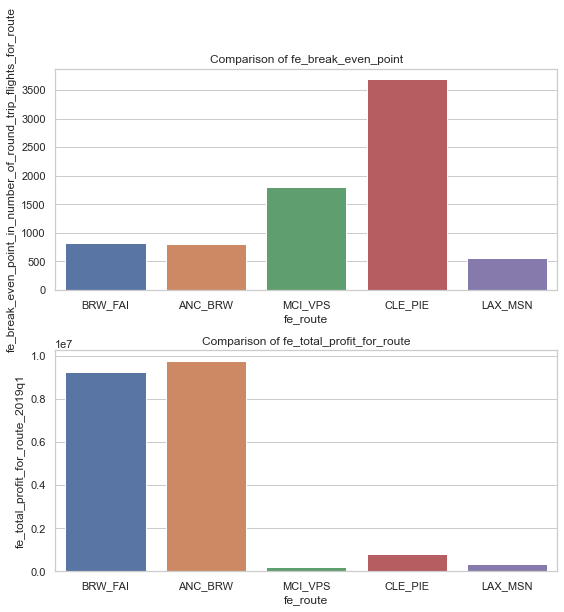

In [43]:
# Clear the previous plot
plt.clf()

# set up dataframe for top 5 routes with minimal delay
minimal_delay = master_df_grouped_by_route_v12.sort_values(by='fe_route_mean_dep_delay').head()

# Reorder dataframe to ensure 'ANC_BRW' and 'BRW_FAI' are adjacent
reordered_routes = minimal_delay.loc[minimal_delay['fe_route'].isin(['ANC_BRW', 'BRW_FAI'])].append(
    minimal_delay.loc[~minimal_delay['fe_route'].isin(['ANC_BRW', 'BRW_FAI'])]
)

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))  # Reduced to 2 rows

# Plot for 'fe_total_profit_for_route_2019q1'
sns.barplot(data=reordered_routes, x='fe_route', y='fe_total_profit_for_route_2019q1', ax=axes[1])
axes[1].set_title('Comparison of fe_total_profit_for_route')

# Plot for 'fe_break_even_point_in_number_of_round_trip_flights_for_route'
sns.barplot(data=reordered_routes, x='fe_route', y='fe_break_even_point_in_number_of_round_trip_flights_for_route', ax=axes[0])
axes[0].set_title('Comparison of fe_break_even_point')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



<span style="font-family: serif; font-size: 1.5em;">
WHAT'S NEXT?
</span>

<span style="font-family: serif; font-size: 1em;">
In a more complete analysis I would normalize relevant numeric values in the master dataframe to allow for calculating futher metrics and making better recommendations. For example, in some of the recommendation above I combined considerations like quarterly profitability and mean departure delay. But why not do this more systematically and in a way that is more precise? By normalizing values we might then assign different weights (representing client priorities) to some of the values. We might then simply calculate which routes maximize various weighted, normalized sets of metrics. In this way we might know, with greater precision, which routes fare "best" across weighted sets of considerations. 
</span>

<span style="font-family: serif; font-size: 1em;">
In this quick report I attempted to lean heavily into the client's motto, "On time, for you." But in a more rigorous analysis I would also seek to focus more heavily on financial considerations. This would require some further research regarding what to prioritize. Above I suggested a consideration of "efficiency" -- how "quickly" a route is at breaking even. This derived value would be an interesting metric to track for all routes. Many other metrics that seem to be important are already in the master dataframe -- various components of the total route cost and revenue, flight occupancy rate, and (mean) fare price.
</span>